In [1]:
import math
import torch
import gpytorch
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
from bo_functions import calc_best_error
from bo_functions import calc_ei_basic
from bo_functions import y_plotter
from bo_functions import stdev_plotter
from bo_functions import ei_plotter

In [2]:
# Training data is 10^2 points in [-2,2] inclusive regularly spaced
Theta1 = np.linspace(-2,2,10) #1x10
Theta2 = np.linspace(-2,2,10) #1x10

#Creates a mesh for training data
train_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform Arrays 10x10 (.T turns this into 10 10x2 arrays)
x = torch.tensor(np.linspace(-2,2,5)) #1x5

#Lists every combination of training Theta1 and Theta2
train_T = torch.tensor(train_mesh.T.reshape(-1, 2))#100x2

#Set noise parameters and true value of Theta to generate training data
noise_mean = 0
noise_std = 0.1**2
Theta_True = torch.tensor([1,-1]) #1x2

#Creates noise values with a certain stdev and mean from a normal distribution
noise = torch.tensor(np.random.normal(size=len(x),loc = noise_mean, scale = noise_std)) #1x5

# True function is y=T1*x + T2*x^2 + x^3 with Gaussian noise
y_true =  Theta_True[0]*x + Theta_True[1]*x**2 +x**3 + noise #1x5

#Creates an array for train_y that will be filled with the for loop
train_y = torch.tensor(np.zeros(len(train_T))) #1 x 100

#Iterates over evey combination of theta to find the SSE for each combination
for i in range(len(train_T)):
    theta_1 = train_T[i,0] #100x1 
    theta_2 = train_T[i,1] #100x1
    y_exp = theta_1*x + theta_2*x**2 +x**3 + noise #100 x5
    train_y[i] = sum((y_true - y_exp)**2) # A number

In [3]:
# We will use the simplest form of GP model, exact inference
#This class is the Exact GP model and we are defining the class as ExactGPModel
class ExactGPModel(gpytorch.models.ExactGP): #Exact GP does not add noise
    """
    The base class for any Gaussian process latent function to be used in conjunction
    with exact inference.

    Parameters
    ----------
    torch.Tensor train_inputs: (size n x d) The training features :math:`\mathbf X`.
    
    torch.Tensor train_targets: (size n) The training targets :math:`\mathbf y`.
    
    ~gpytorch.likelihoods.GaussianLikelihood likelihood: The Gaussian likelihood that defines
        the observational distribution. Since we're using exact inference, the likelihood must be Gaussian.
    
    Methods
    -------
    The :meth:`__init__` function takes training data and a likelihood and computes the objects of mean and covariance 
    for the forward method

    The :meth:`forward` function should describe how to compute the prior latent distribution
    on a given input. Typically, this will involve a mean and kernel function.
    The result must be a :obj:`~gpytorch.distributions.MultivariateNormal`.
    
    Returns
    -------
    Calling this model will return the posterior of the latent Gaussian process when conditioned
    on the training data. The output will be a :obj:`~gpytorch.distributions.MultivariateNormal`.
    """

    def __init__(self, train_T, train_y, likelihood):
        """
        Initializes the model
        
        Parameters
        ----------
        self : A class,The model itself. In this case, gpytorch.models.ExactGP
        train_T : tensor, The inputs of the training data
        train_y : tensor, the output of the training data
        likelihood : bound method, the lieklihood of the model. In this case, it must be Gaussian
        
        """
        #Initializes the GP model with train_Y, train_y, and the likelihood
        ##Calls the __init__ method of parent class
        super(ExactGPModel, self).__init__(train_T, train_y, likelihood)
        #Defines a constant prior mean on the GP. Used in the forward method
        self.mean_module = gpytorch.means.ConstantMean()
        #Defines prior covariance matrix of GP to a scaled RFB Kernel. Used in the forward method
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 

    def forward(self, x):
        """
        A forward method that takes in some (n×d) data, x, and returns a MultivariateNormal with the prior mean and 
        covariance evaluated at x. In other words, we return the vector μ(x) and the n×n matrix Kxx representing the 
        prior mean and covariance matrix of the GP.
        
        Parameters
        ----------
        self : A class,The model itself. In this case, gpytorch.models.ExactGP
        x : tensor, first input when class is called
        
        Returns:
        Vector μ(x)
        
        """
        #Defines the mean of the GP based off of x
        mean_x = self.mean_module(x) #1x100
        #Defines the covariance matrix based off of x
        covar_x = self.covar_module(x) #100 x 100 covariance matrix
        #Constructs a multivariate normal random variable, based on mean and covariance. 
            #Can be multivariate, or a batch of multivariate normals
            #Returns multivariate normal distibution gives the mean and covariance of the GP        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x) #Multivariate dist based on 1x100 tensor

# initialize likelihood and model
##Assumes a homoskedastic noise model p(y | f) = f + noise
likelihood = gpytorch.likelihoods.GaussianLikelihood()

#Defines our model in terms of the class parameters above
model = ExactGPModel(train_T, train_y, likelihood)

In [4]:
# Find optimal model hyperparameters
training_iter = 300

#Puts the model in training mode
model.train()

#Puts the likelihood in training mode
likelihood.train()

# Use the adam optimizer
    #algorithm for first-order gradient-based optimization of stochastic objective functions
    # The method is also appropriate for non-stationary objectives and problems with very noisy and/or sparse gradients. 
    #The hyper-parameters have intuitive interpretations and typically require little tuning.
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  #Needs GaussianLikelihood parameters, and a learning rate
    #lr default is 0.001

# Calculate"Loss" for GPs

#The marginal log likelihood (the evidence: quantifies joint probability of the data under the prior)
#returns an exact MLL for an exact Gaussian process with Gaussian likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model) #Takes a Gaussian likelihood and a model, a bound Method
#iterates a give number of times
for i in range(training_iter): #0-299
    # Zero gradients from previous iteration - Prevents past gradients from influencing the next iteration
    optimizer.zero_grad() 
    # Output from model
    output = model(train_T) # A multivariate norm of a 1 x 100 tensor
    # Calc loss and backprop gradients
    #Minimizing -logMLL lets us fit hyperparameters
    loss = -mll(output, train_y) #A number (tensor)
    #computes dloss/dx for every parameter x which has requires_grad=True. 
    #These are accumulated into x.grad for every parameter x
    loss.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.base_kernel.lengthscale.item(),
#          model.likelihood.noise.item()
#     ))
    #optimizer.step updates the value of x using the gradient x.grad. For example, the SGD optimizer performs:
    #x += -lr * x.grad
    optimizer.step()

In [5]:
# Get into evaluation (predictive posterior) mode
#Puts model in evaluation mode
model.eval()
#Puts likelihood in evaluation mode
likelihood.eval()

#Define Testing Data
test_Theta1 =  np.linspace(-1,1,5) #1x5
test_Theta2 =  np.linspace(-1,1,5) #1x5
test_mesh = np.array(np.meshgrid(test_Theta1, test_Theta2)) #2 Uniform 5x5 arrays
test_T = torch.tensor(test_mesh.T.reshape(-1, 2)) #25 x 2

In [6]:
#Code for EI

with gpytorch.settings.fast_pred_var(), torch.no_grad():
#torch.no_grad() 
    #Disabling gradient calculation is useful for inference, 
    #when you are sure that you will not call Tensor.backward(). It will reduce memory consumption
    #Note: Can't use np operations on tensors where requires_grad = True
#gpytorch.settings.fast_pred_var() 
    #Use this for improved performance when computing predictive variances. 
    #Good up to 10,000 data points
#Predicts data points for model (sse) by sending the model through the likelihood
    observed_pred = likelihood(model(test_T)) #1 x 25
    
#Calculates model mean  
model_mean = observed_pred.mean
#Calculates the variance of each data point
model_variance = observed_pred.variance
#Calculates the standard deviation of each data point
model_stdev = np.sqrt(observed_pred.variance)
sse_model = observed_pred.loc.numpy() #1 x 25

#Formats sse data points into a suitable graphing form    
sse_map = sse_model.reshape(len(test_Theta1),-1) #5 x 5
#Formats stdev data points into suitable graphing form
stdev_map = model_stdev.reshape(len(test_Theta1),-1) #5 x 5

#Finds the index where sse is the smallest and finds which Theta combination corresponds to that value
Theta_Opt_GP = test_T[np.argmin(sse_model)].numpy() #1x2
print("The GP predicts that Theta1 =",Theta_Opt_GP[0],"and Theta2 =", Theta_Opt_GP[1])

explore_bias = 0
best_error = calc_best_error(test_T, x, sse_model, noise)
ei = calc_ei_basic(best_error,model_mean,model_variance, explore_bias)
    
#     #If variance is zero this is important 
#     with np.errstate(divide = 'warn'):
#         #Creates upper and lower bounds and described by Nilay's word doc
#         bound_upper = ((sse_true[j] - model_mean[j]) +np.sqrt(best_error))/model_variance[j]
#         bound_lower = ((sse_true[j] - model_mean[j]) -np.sqrt(best_error))/model_variance[j]
        
#         #Creates EI terms in terms of Nilay's word doc
#         ei_term1_comp1 = norm.cdf(bound_upper) - norm.cdf(bound_lower)
#         ei_term1_comp2 = best_error - (sse_true[j] - model_mean[j])**2
        
#         ei_term2_comp1 = (sse_true[j] - model_mean[j])*model_stdev[j]
#         ei_term2_comp2 = norm.pdf(bound_upper) - norm.pdf(bound_lower)
        
#         ei_term3_comp1 = (1/2)*norm.pdf(bound_upper/np.sqrt(2))
#         ei_term3_comp2 = -norm.pdf(bound_upper)*bound_upper
#         ei_term3_comp3 = (1/2)*norm.pdf(bound_lower/np.sqrt(2))
#         ei_term3_comp4 = -norm.pdf(bound_lower)*bound_lower
        
#         ei_term3_psi_upper = ei_term3_comp1 + ei_term3_comp2
#         ei_term3_psi_lower = ei_term3_comp3 + ei_term3_comp4
        
#         ei_term1 = ei_term1_comp1 + ei_term1_comp2
#         ei_term2 = ei_term2_comp1 + ei_term2_comp2
#         ei_term3 = -model_variance[j]*(ei_term3_psi_upper-ei_term3_psi_lower)
        
#         EI[j] = ei_term1 + ei_term2 + ei_term3
       
# print("The best error of", round(best_error,3), "is found at Theta 1 =", best_theta[0].numpy(), "and Theta 2 =", best_theta[1].numpy())
# print("The best EI of", round(np.max(EI),3), "is found at Theta 1 =", test_T[np.argmax(EI)][0].numpy(), "and Theta 2 =", test_T[np.argmax(EI)][1].numpy())

#Reshapes EI so that it can be plotted
ei_map = ei.reshape(len(test_Theta1),-1)

The GP predicts that Theta1 = 1.0 and Theta2 = -1.0


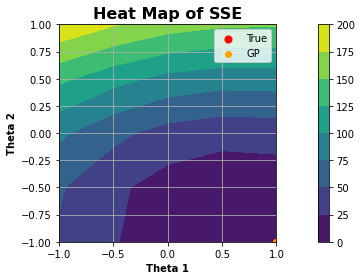

In [7]:
y_plotter(test_mesh, sse_map, Theta_True, Theta_Opt_GP)

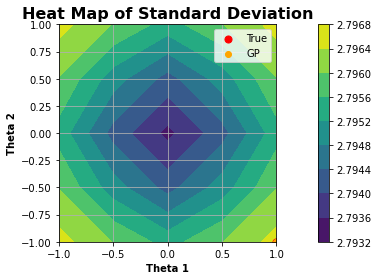

In [8]:
stdev_plotter(test_mesh, stdev_map,Theta_True, Theta_Opt_GP)

In [9]:
ei_plotter(test_mesh, ei_map, Theta_True, Theta_Opt_GP)

NameError: name 'EI_map' is not defined